In [1]:
!git clone https://github.com/gjy3035/C-3-Framework.git

fatal: destination path 'C-3-Framework' already exists and is not an empty directory.


In [2]:
import azureml
from azureml.core import Workspace, Datastore, Experiment, Environment, Model
from azureml.core.resource_configuration import ResourceConfiguration
import urllib.request
from pathlib import Path
!pip install easydict
import easydict
from easydict import EasyDict

In [3]:
# This will open an device login prompt. Login with your credentials that have access to the workspace.
# Connect to the workspace
ws = Workspace.from_config()
print("Using workspace:",ws.name,"in region", ws.location)

# Connect to the default datastore
ds = ws.get_default_datastore()
print("Datastore:",ds.name)

Using workspace: pai_cc in region westeurope
Datastore: workspaceblobstore


In [14]:
# Create dataset directory
Path("dataset").mkdir(parents=True, exist_ok=True)

In [15]:
# Upload data to the data store
#XCA update dataset/SHHB
ds.upload('dataset', target_path='SHHB', overwrite=False, show_progress=True)
#ds.upload('dataset', target_path='cc_data/SHHB', overwrite=False, show_progress=True)

Uploading an estimated of 0 files
Uploaded 0 files


$AZUREML_DATAREFERENCE_7dcb4b0d0169417db072f9ca7595b3f6

In [53]:
#se connecter au serveur
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

cluster_name = "PAI-CC"
# XCA min to 1 and low to high
try:
    cluster = ComputeTarget(workspace=ws, name=cluster_name)
    print('Using compute cluster:', cluster_name)
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NV6', #Standard_NC24 before STANDARD_NC12 XCA update
                                                           vm_priority='highpriority',
                                                           min_nodes=1,
                                                           max_nodes=1)
    cluster = ComputeTarget.create(ws, cluster_name, compute_config)
    cluster.wait_for_completion(show_output=True)

Using compute cluster: PAI-CC


In [54]:
%%writefile C-3-Framework/trainRemote.py

import os
import argparse
import shutil
import numpy as np
import torch
import easydict
#XCA update

from torch import optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from models.CC import CrowdCounter
from misc.utils import *
from config import cfg
from easydict import EasyDict
#XCA update

from trainer import Trainer
# Prepare Trainer for AzureML by overide utils logger with Azure logger TDB
def logger(exp_path, exp_name, work_dir, exception, resume=False):
    from tensorboardX import SummaryWriter
    if not os.path.exists(exp_path):
        os.mkdir(exp_path)
    writer = SummaryWriter(exp_path+ '/' + exp_name)
    log_file = exp_path + '/' + exp_name + '/' + exp_name + '.txt'
    print('log file:', log_file) #XCA update
    return writer, log_file

class AzureMLTrainer(Trainer):

    def __init__(self, dataloader, cfg_data, pwd):
        self.cfg_data = cfg_data

        self.data_mode = cfg.DATASET
        self.exp_name = cfg.EXP_NAME
        self.exp_path = cfg.EXP_PATH
        self.pwd = pwd

        self.net_name = cfg.NET
        self.net = CrowdCounter(cfg.GPU_ID,self.net_name).cuda()
        self.optimizer = optim.Adam(self.net.CCN.parameters(), lr=cfg.LR, weight_decay=1e-4)
        # self.optimizer = optim.SGD(self.net.parameters(), cfg.LR, momentum=0.95,weight_decay=5e-4)
        self.scheduler = StepLR(self.optimizer, step_size=cfg.NUM_EPOCH_LR_DECAY, gamma=cfg.LR_DECAY)          

        self.train_record = {'best_mae': 1e20, 'best_mse':1e20, 'best_model_name': ''}
        self.timer = {'iter time' : Timer(),'train time' : Timer(),'val time' : Timer()} 

        self.epoch = 0
        self.i_tb = 0
        
        if cfg.PRE_GCC:
            self.net.load_state_dict(torch.load(cfg.PRE_GCC_MODEL))
            print("Print model loaded", cfg.PRE_GCC_MODEL)

        self.train_loader, self.val_loader, self.restore_transform = dataloader()

        self.writer, self.log_txt = logger(self.exp_path, self.exp_name, self.pwd, 'exp', resume=cfg.RESUME)
        
#------------Process Inputs------------
parser = argparse.ArgumentParser(description='AlexNet Trainer')
parser.add_argument('--data_folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--max_epoch', type=int, default=32, help='number of epochs to train') #XCA change to 10 from 100

args = parser.parse_args()

cfg.DATASET = 'SHHB'
cfg.NET = 'AlexNet'
cfg.MAX_EPOCH = args.max_epoch

#------------Prepare Data------------
#SHHB_PATH = os.path.join(args.data_folder, 'cc_data/{}'.format(cfg.DATASET))
#XCA update
SHHB_PATH = './dataset/SHHB/' # working remote but laterom error

print('path:', SHHB_PATH) #XCA update

if not os.path.isdir(os.path.join(SHHB_PATH,'train')):
    from zipfile import ZipFile
    # Create a ZipFile Object and load sample.zip in it
    with ZipFile(os.path.join(SHHB_PATH,'Dataset_PAi_27_landscape.zip'), 'r') as zipObj:
        zipObj.extractall(SHHB_PATH)
        os.rename(os.path.join(SHHB_PATH,'train_data'), os.path.join(SHHB_PATH,'train'))
        os.rename(os.path.join(SHHB_PATH,'test_data'), os.path.join(SHHB_PATH,'test'))
os.path.abspath('')
os.path.split(os.path.realpath(os.path.abspath('')))

#------------Start Training------------
from datasets.SHHB.loading_data import loading_data 
from datasets.SHHB.setting import cfg_data 
cfg_data.DATA_PATH = SHHB_PATH
pwd = os.path.split(os.path.realpath(os.path.abspath('')))[0]
cc_trainer = AzureMLTrainer(loading_data,cfg_data,pwd)
cc_trainer.forward()

#------------Copy Model Output------------        
mcnn_model = shutil.copytree(os.path.join(cfg.EXP_PATH, cfg.EXP_NAME), './outputs/exp')

Overwriting C-3-Framework/trainRemote.py


In [55]:
# Create an experiment or connect if it exists
from azureml.train.estimator import Estimator
experiment_name = "crowdcounting_SHHB_AlexNet_1GPU_PAI27_epoch_32_1647356520_52d79b51" #UCF50_AlexNet_4000epoch.pth
exp = Experiment(workspace=ws, name=experiment_name)

In [56]:
script_params = {
    '--data_folder': ds,
}

cc_est = Estimator(source_directory='./C-3-Framework',
                   script_params=script_params,
                   compute_target=cluster,
                   use_gpu=True,
                   entry_script='trainRemote.py',
                   pip_packages=['torch',
                                 'torchvision',
                                 'tensorboardX',
                                 'tensorboard',
                                 'tensorflow',
                                 'easydict',
                                 'pandas',
                                 'numpy',
                                 'scipy'])

In [57]:
run = exp.submit(cc_est) #soumettre le code sur le serveur

Submitting /mnt/batch/tasks/shared/LS_root/mounts/clusters/pai-cc/code/Users/julio.caballero.ramos/C-3-Framework directory for run. The size of the directory >= 25 MB, so it can take a few minutes.


In [58]:
# Select a previous run
run = [r for r in exp.get_runs() if r.id == 'crowdcounting_SHHB_AlexNet_1GPU_PAI27_epoch_32_1647356520_52d79b51_1649178960_21a58edf'][0] #XCA to be updated to the last value of the Run Id from the experiment console
#cc_MCNN_1645707248_946378a5 from XCA run old cc_MCNN_1583914876_137247d1   new cc_MCNN_xca_1645734773_6abcba4a

In [59]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

In [61]:
model = run.register_model(model_name = 'AlexNet-CrowdCounting-Model-PAI_ep_32', 
                     model_path = './outputs/exp/all_ep_21_mae_5.1_mse_6.8.pth',  # test with Users/xcallens/pretrainedmodel/UCF50_AlexNet_4000epoch.pth before ok outputs/exp/all_ep_97_mae_42.0_mse_65.0.pth all_ep_11_mae_58.2_mse_79.5 try outputs/exp/all_ep_11_mae_58.2_mse_79.5.pth all_ep_97_mae_42.0_mse_65.0.pth 
                     model_framework =  Model.Framework.CUSTOM,
                     description = 'AlexNet Crowd Counting Model',
                     tags={'area': 'CV', 'type': 'AlexNet', 'model_author': "C-3-Framework"},
                     resource_configuration = ResourceConfiguration(cpu=1, gpu=1, memory_in_gb=2))

print('version:', model.version)

version: 1


In [62]:
#inclure le pth sur un dossier 'temp'
Path("./temp").mkdir(parents=True, exist_ok=True)
model.download(exist_ok=True,target_dir="./temp")

'temp/all_ep_21_mae_5.1_mse_6.8.pth'

In [5]:
#import easydict
#from easydict import EasyDict

from matplotlib import pyplot as plt
import matplotlib
import random
import torch
import sys


sys.path.insert(0, './C-3-Framework')
from torch.autograd import Variable
import torchvision.transforms as standard_transforms
import misc.transforms as own_transforms
import pandas as pd

from models.CC import CrowdCounter
from config import cfg
cfg.NET = "AlexNet"
from misc.utils import *
import scipy.io as sio
from PIL import Image, ImageOps


torch.cuda.set_device(0)
torch.backends.cudnn.benchmark = True

In [6]:
cfg.NET

'AlexNet'

In [11]:
mean_std = ([0.452016860247, 0.447249650955, 0.431981861591],[0.23242045939, 0.224925786257, 0.221840232611])
img_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])
restore = standard_transforms.Compose([
        own_transforms.DeNormalize(*mean_std),
        standard_transforms.ToPILImage()
    ])
pil_to_tensor = standard_transforms.ToTensor()

img_path = './airporttest/20.jpg' #Users/xcallens/airporttest/airportcongestion1.jpg
model_path = './temp/all_ep_31_mae_18.4_mse_28.5.pth'

#all_ep_97_mae_42.0_mse_65.0
#    [mae 42.04 mse 65.05], [val loss 0.0106]
#===============+++++++++++++++===============

In [12]:
net = CrowdCounter(cfg.GPU_ID,'AlexNet')
print('Nb of GPUS',cfg.GPU_ID) #XCA update
net.load_state_dict(torch.load(model_path))
net.cuda()
net.eval()

Nb of GPUS [0]


CrowdCounter(
  (CCN): AlexNet(
    (layer1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
    (layer1plus): Sequential(
      (0): ReLU(inplace=True)
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
    (layer2plus_to_5): Sequential(
      (0): ReLU(inplace=True)
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU(inplace=True)
      (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
    )
    (de_pred): Sequential(
      (0): Conv2d(
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
        (relu): ReLU(inplace=True)
      )
      (1): Co

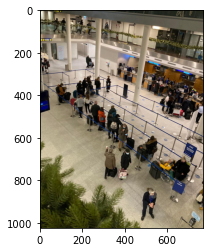

In [13]:
img = Image.open(img_path)
plt.imshow(img)

In [14]:
if img.mode == 'L':
    img = img.convert('RGB')
img = img_transform(img)
with torch.no_grad():
    img = Variable(img[None,:,:,:]).cuda()
    pred_map = net.test_forward(img)

pred_map = pred_map.cpu().data.numpy()[0,0,:,:]
pred = np.sum(pred_map)/100.0
pred_map = pred_map/np.max(pred_map+1e-20)
print("{} people".format(pred.round()))

58.0 people


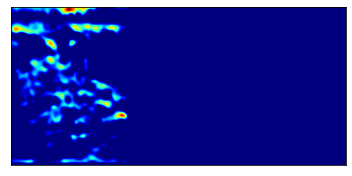

In [64]:
pred_frame = plt.gca()
plt.imshow(pred_map, 'jet')
pred_frame.axes.get_yaxis().set_visible(False)
pred_frame.axes.get_xaxis().set_visible(False)